<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [2]:
RANDOM_STATE = 42
N_FOLDS = 5

In [24]:
import os
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [35]:
dataset_files = sorted(glob('data/chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [36]:
with open('data/chicago-taxi-rides-2016/column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [37]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [38]:
assert df.shape == (5432105, 18)

**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- <font color='green'>tips</font>
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- <font color='green'>логарифмирование</font>
- никакие

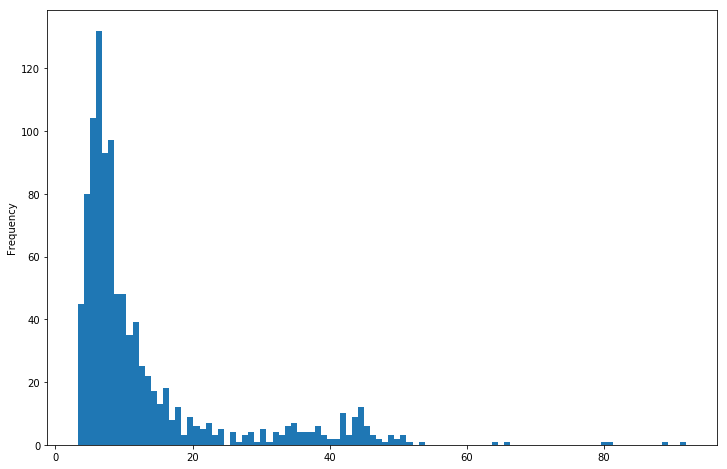

In [7]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

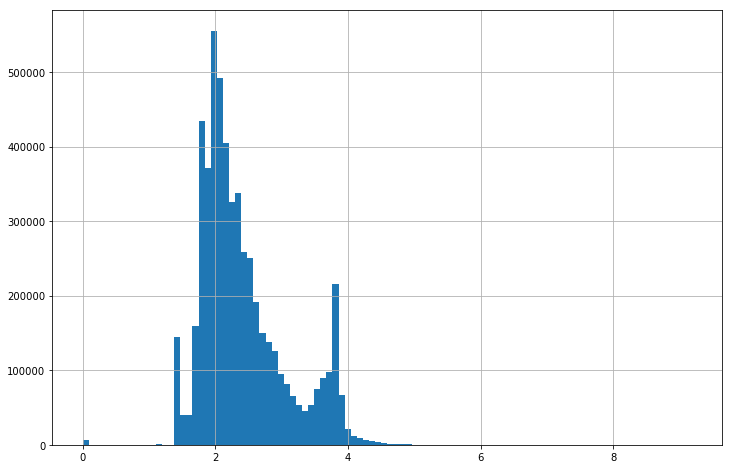

In [50]:
np.log(target+1).hist(bins=100)

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- <font color='green'>43.66</font>

In [124]:
from geopy import distance
from joblib import Parallel, delayed

In [146]:
%%time
d = Parallel(n_jobs=-1)(delayed(distance.great_circle)((column_remapping['pickup_latitude'][str(int(r['pickup_latitude']))], 
                                                   column_remapping['pickup_longitude'][str(int(r['pickup_longitude']))]),  
                                                  (column_remapping['dropoff_latitude'][str(int(r['dropoff_latitude']))], 
                                                   column_remapping['dropoff_longitude'][str(int(r['dropoff_longitude']))]))
                   for i, r in df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]\
                               .dropna().iterrows())

Wall time: 8min 12s


In [148]:
np.max(list(map(lambda x: x.km, d)))

43.662892734777216

In [80]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()

In [81]:
pickup_dropoff.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,199.0,510.0,199.0,510.0
3,686.0,500.0,686.0,500.0
5,599.0,346.0,660.0,120.0
7,527.0,24.0,527.0,24.0
8,210.0,470.0,744.0,605.0


Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [149]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)

# cross_val_score максимизирует метрику, так что вместо 
# минимизации MSE по факту происходит максимизация отрицательного MSE.
# Поэтому выведем модуль среднего значения метрики на кросс-валидации.
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

972.945062228
Wall time: 15.4 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- <font color='green'>не зафиксирован random seed</font>
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [150]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

877.7118181861897

In [172]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

for droped in ['tips', 'tolls', 'trip_seconds', 'trip_miles']:   
    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    m = np.abs(cross_val_score(pipeline,
                    X=X_data.drop(droped, axis=1).values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
            .mean())
    print('mean =',m,'with droped',droped)

mean = 908.722836036 with droped tips
mean = 719.773903068 with droped tolls
mean = 905.274108233 with droped trip_seconds
mean = 879.313958264 with droped trip_miles


**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- <font color='green'>tolls </font>
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [174]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

Wall time: 1min 27s


In [176]:
%%time
#Base model
pipeline = make_pipeline(StandardScaler(),
                     LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
mt = np.abs(cross_val_score(pipeline,
                X=X_data.copy().values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())
print('base model mean =',m,'with t', i)
    
for i, t in enumerate((t1, t2, t3, t4)):
    X_data_changed = X_data.copy()
    X_data_changed['time'] = t
        
    # Ваш код здесь
    pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    mt = np.abs(cross_val_score(pipeline,
                    X=X_data_changed.values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())
    print('mean =',m,'with t', i)

base model mean = 879.313958264 with t 3
mean = 879.313958264 with t 0
mean = 879.313958264 with t 1
mean = 879.313958264 with t 2
mean = 879.313958264 with t 3
Wall time: 54.7 s


** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- <font color='green'>новые признаки не улучшают модель, т.к. такова природа данных</font>
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

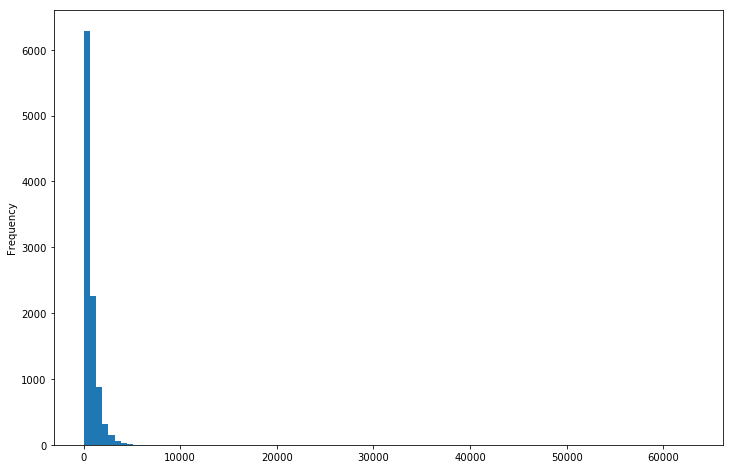

In [156]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

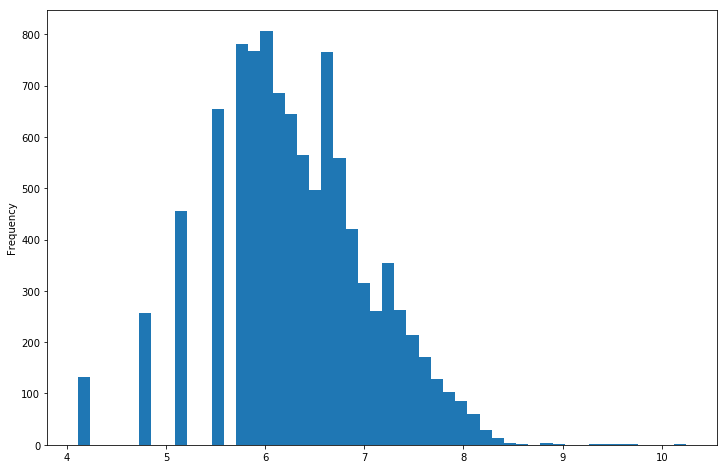

In [170]:
seconds.sample(10000).apply(lambda x: 
                            np.log(x+1)).plot(kind='hist', bins=50);

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- чтобы запутать читателей
- чтобы получить бимодальное распределение
- для скорости вычисления
- <font color='green'>во избежание `ValueError`</font>